In [ ]:
!nvidia-smi

Tue Aug  8 14:55:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Goal is to recreate paper PubMed 200 RCT

Pubmed paper : https://arxiv.org/pdf/1710.06071.pdf

--paper we are deriving our model from:
Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts: https://arxiv.org/pdf/1612.05251.pdf

Downloading the dataset

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 11.84 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


dev is validation dataset

In [ ]:
import os

filenames = [data_dir+i for i in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
#writing function
def file_to_list(dir_path):
  """Converts dir_path to abstract list"""
  with open(dir_path, 'r') as reader:
    text = reader.read()
    text_list = text.split('\n\n')
  return text_list


In [ ]:
# # testing for function
# f = open(filenames[0], 'r')
# train_text = f.read()

# train_text_list = train_text.split('\n\n')
# len(train_text),  train_text_list[:4]

In [ ]:
abstract_list = file_to_list(filenames[2])
len(abstract_list), abstract_list[:2]

(2501,
 ["###24845963\nBACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\nRESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\nRESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\nRESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\nRESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\nRESULTS\tWhen mean hemod

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]

In [ ]:
def abstract_to_list(filename):
  abstract_list = file_to_list(filename)
  train_dict_l = []

  for i in abstract_list:
    lines = i.split("\n")
    total_lines = len(lines)
    for i in range(1, total_lines):
      line_data = {}
      target, text =lines[i].split("\t")
      line_data["target"] = target
      line_data["text"] = text.lower()
      line_data["line_number"] = i-1
      line_data["total_lines"] = total_lines - 2
      train_dict_l.append(line_data)
  return train_dict_l




##change everytime files to dictionary

In [ ]:
test_dict = abstract_to_list(filenames[2])
val_dict = abstract_to_list(filenames[1])
train_dict = abstract_to_list(filenames[0])
len(train_dict), len(val_dict), len(test_dict)

(180040, 30212, 30135)

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

train_df = pd.DataFrame(train_dict)
val_df = pd.DataFrame(val_dict)
test_df = pd.DataFrame(test_dict)

train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


Text(0.5, 1.0, 'number of sentences per label')

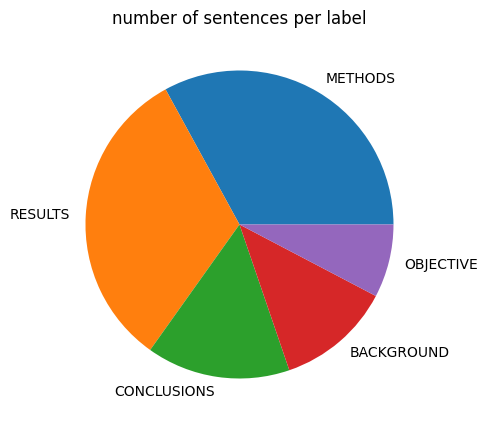

In [ ]:
plt.figure(figsize = (7,5))
plt.pie(x=train_df.target.value_counts(), labels = train_df.target.value_counts().index)
plt.title("number of sentences per label")

<Axes: ylabel='Frequency'>

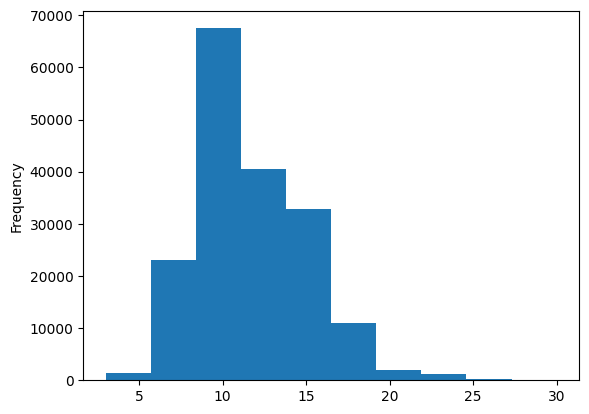

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

#Encoding the labels

##**LabelEncoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train_labels_le = le.fit_transform(train_df["target"].to_numpy())
val_labels_le = le.transform(val_df["target"].to_numpy())
test_labels_le = le.transform(test_df["target"].to_numpy())

train_labels_le

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
le.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
num_classes = len(le.classes_)
class_names = le.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

##**OneHotEncoding**

In [ ]:
from sklearn.preprocessing import OneHotEncoder

one_h_e = OneHotEncoder(sparse = False)

train_onehot_encoded = one_h_e.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_onehot_encoded = one_h_e.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_onehot_encoded = one_h_e.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_df["target"][:5], train_onehot_encoded[:5]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(0    OBJECTIVE
 1      METHODS
 2      METHODS
 3      METHODS
 4      METHODS
 Name: target, dtype: object,
 array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.]]))

#Base Model 0

to set a baseline for our model evaluations

In [ ]:
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.feature_extraction.text import TfidfVectorizer

# from sklearn.pipeline import Pipeline

# base_model_0 = Pipeline([
#     ("tf-idf", TfidfVectorizer()),
#     ("clf", MultinomialNB())
# ])

# base_model_0.fit(train_sentences, train_labels_le)

# base_model_0_score = base_model_0.score(val_sentences, val_labels_le)
# model_0_preds = base_model_0.predict(val_sentences)

# print(f"{base_model_0_score}\n{model_0_preds[:10]}")

In [ ]:
!wget https://raw.githubusercontent.com/forcoding1/Deep-Learning-with-tensorflow/main/helper_tf.py

--2023-08-08 14:55:42--  https://raw.githubusercontent.com/forcoding1/Deep-Learning-with-tensorflow/main/helper_tf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534 [text/plain]
Saving to: ‘helper_tf.py’

helper_tf.py        100%[===================>]     534  --.-KB/s    in 0s      

2023-08-08 14:55:42 (37.4 MB/s) - ‘helper_tf.py’ saved [534/534]



Model 0 results

In [ ]:
# from helper_tf import results

# res_0 = results(val_labels_le, model_0_preds)
# res_0

In [ ]:
import numpy as np
from tensorflow.keras import layers

**Finding the appropriate length for the text vectorization layer**

In [ ]:
sentences_len = [len(i.split()) for i in train_sentences]
sen_mean_len = np.mean(sentences_len)
sen_mean_len

26.338269273494777

(array([2.5486e+04, 7.1478e+04, 4.8888e+04, 2.0260e+04, 7.5560e+03,
        3.4370e+03, 1.4950e+03, 7.3700e+02, 3.2800e+02, 1.6500e+02,
        8.5000e+01, 4.9000e+01, 2.0000e+01, 1.5000e+01, 9.0000e+00,
        6.0000e+00, 8.0000e+00, 8.0000e+00, 3.0000e+00, 2.0000e+00,
        3.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1. ,  12.8,  24.6,  36.4,  48.2,  60. ,  71.8,  83.6,  95.4,
        107.2, 119. , 130.8, 142.6, 154.4, 166.2, 178. , 189.8, 201.6,
        213.4, 225.2, 237. , 248.8, 260.6, 272.4, 284.2, 296. ]),
 <BarContainer object of 25 artists>)

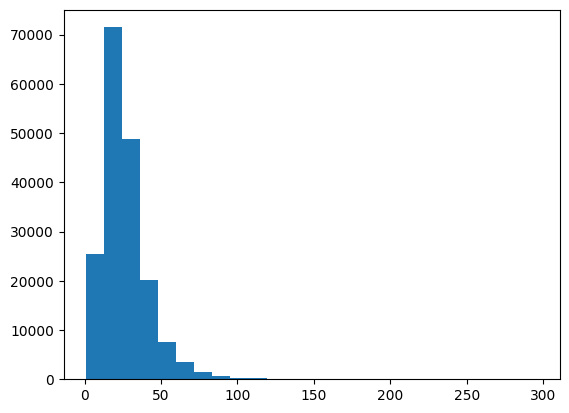

In [ ]:
#plotting the lengths of sentences in training sentences

plt.hist(sentences_len, bins = 25)

In [ ]:
#length of 95 percentile of the texts

output_seq_len = int(np.percentile(sentences_len, 95))
output_seq_len

55

We found that 95 percentile of them occur under 55 length

In [ ]:
max(sentences_len)

296

#Text Vectorization

In [ ]:
#from table 2 in pubmed

max_tokens = 68000

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vect = TextVectorization(
    max_tokens = max_tokens,
    output_sequence_length = output_seq_len
)

In [ ]:
text_vect.adapt(train_sentences)

In [ ]:
import random

r_sen = random.choice(train_sentences)
vect_sen = text_vect([r_sen])
l = len(r_sen.split())

print(f"Text: {r_sen}")
print(f"\nLength: {l}")
print(f"\nVectorized text: {vect_sen}")

Text: the control arm received an average of @ blood transfusions , whereas the test arm received @ ( p = @ ) .

Length: 23

Vectorized text: [[   2   35  207   80   26  405    4  107 3611  436    2  128  207   80
    14    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
rct_20k_text_vocab = text_vect.get_vocabulary()
vocab_length = len(rct_20k_text_vocab)
print(f"Length of vocabulary: {vocab_length}")
print(f"\n5 most used words: {rct_20k_text_vocab[:5]}")
print(f"\n5 least used words: {rct_20k_text_vocab[-5:]}")

Length of vocabulary: 64841

5 most used words: ['', '[UNK]', 'the', 'and', 'of']

5 least used words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
text_vect.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

#Embedding Layer

In [ ]:
token_emb = layers.Embedding(
    input_dim = vocab_length,
    output_dim = 128,
    mask_zero = True,
    name = "token_embedding"
)

In [ ]:
print(f"Original Sentence: {r_sen}")
print(f"\nVectorized output: {vect_sen}")
emb_sen = token_emb(vect_sen)
print(f"\nEmbedding output {emb_sen}")
print(f"\nShape of embedding output: {emb_sen.shape}")

Original Sentence: the control arm received an average of @ blood transfusions , whereas the test arm received @ ( p = @ ) .

Vectorized output: [[   2   35  207   80   26  405    4  107 3611  436    2  128  207   80
    14    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Embedding output [[[-0.00532453  0.03859201  0.04707544 ... -0.00983866  0.00675974
   -0.01732507]
  [-0.03672794 -0.01549747  0.0325872  ... -0.01122002 -0.00251256
   -0.00298097]
  [ 0.02795762  0.04197169 -0.03481774 ... -0.04042461 -0.01181079
   -0.00553057]
  ...
  [ 0.03615984 -0.01266976 -0.01830342 ...  0.0253802   0.00162071
    0.0362576 ]
  [ 0.03615984 -0.01266976 -0.01830342 ...  0.0253802   0.00162071
    0.0362576 ]
  [ 0.03615984 -0.01266976 -0.01830342 ...  0.0253802   0.00162071
    0.0362576 ]]]

Shape of embedding output: (1, 55, 128)


#tf.Dataset


In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_onehot_encoded))
val_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_onehot_encoded))
test_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_onehot_encoded))
train_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_data.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#Model 1: CONV1D

In [ ]:
# from tensorflow.keras import Model

# inputs = layers.Input(shape = (1,), dtype = tf.string)
# vect = text_vect(inputs)
# emb = token_emb(vect)
# x = layers.Conv1D(128, kernel_size = 5, padding = "same", activation = "relu")(emb)
# x = layers.GlobalAveragePooling1D()(x)
# outputs = layers.Dense(num_classes, activation = "softmax")(x)

# model_1 = Model(inputs, outputs, name = "Conv1D_Model")

# model_1.compile(
#     loss = "categorical_crossentropy",
#     optimizer = tf.keras.optimizers.Adam(),
#     metrics = ["accuracy"]
# )

In [ ]:
# model_1.summary()

In [ ]:
# model_1.fit(
#     train_dataset,
#     steps_per_epoch = (0.1 * len(train_dataset)),
#     epochs = 7,
#     validation_data = val_dataset,
#     validation_steps = (0.1 * len(val_dataset))
# )

In [ ]:
# model_1.evaluate(val_dataset)

In [ ]:
# model_1_pred_probs = model_1.predict(val_dataset)
# model_1_pred_probs[:5]

##results of model 1

In [ ]:
# model_1_preds = tf.argmax(model_1_pred_probs, axis = 1)
# model_1_preds[:5]

In [ ]:
# res_1 = results(val_labels_le, model_1_preds)
# res_1

In [ ]:
# import tensorflow_hub as hub

# preprocessor = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# encoder = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4",
#     trainable=True)

# preprocessed_inp = preprocessor.transform(train_data)
# encoded_inp = encoder.fit_transform(preprocessed_inp)



#model 2: feature extraction

##importing universal sentence encoder

In [ ]:
import tensorflow_hub as hub

embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                  trainable=False,
                  name="universal_sentence_encoder"
)


In [ ]:
random_sentence = random.choice(train_sentences)

emb = embed([random_sentence])
print(f"Sentence :{random_sentence}\n")
print(f"Embedded :{emb[0][:20]}\n")
print(f"shape of embedding :{len(emb[0])}\n")
print(f"shape of output:{emb.shape}\n")

Sentence :using clinical psa diagnosis as the standard for comparison , questionnaire accuracy was assessed by calculating sensitivity/specificity and positive/negative predictive values .

Embedded :[-0.04544464 -0.05124469 -0.07063723  0.01633538  0.06424543 -0.04890108
 -0.01532568 -0.01455168 -0.01411084  0.06581119  0.08209201 -0.00442058
 -0.04409149  0.01939512 -0.03831273 -0.01150006 -0.08234658  0.0661278
  0.0088834  -0.02804359]

shape of embedding :512

shape of output:(1, 512)



##building model

In [ ]:

# inputs = layers.Input(shape = [], dtype = tf.string)
# embedding = embed(inputs)
# x = layers.Dense(128, activation = "relu")(embedding)
# outputs = layers.Dense(num_classes, activation = "softmax")(x)

# model_2 = tf.keras.Model(
#     inputs, outputs, name = "Feature_Extraction_use"
# )

# model_2.compile(
#     loss = "categorical_crossentropy",
#     optimizer = tf.keras.optimizers.Adam(),
#     metrics = ["accuracy"]
# )

# model_2.summary()

In [ ]:
# model_2.fit(
#     train_dataset,
#     epochs = 7,
#     steps_per_epoch = int(0.1 * len(train_dataset)),
#     validation_data = val_dataset,
#     validation_steps = int(0.1 * len(val_dataset))
# )

In [ ]:
# model_2.evaluate(val_dataset)

In [ ]:
# model_2_pred_probs = model_2.predict(val_dataset)
# model_2_preds = tf.argmax(model_2_pred_probs, axis = 1)
# model_2_preds[:10]

##model 2 results

In [ ]:
# res_2 = results(
#     val_labels_le,
#     model_2_preds
# )

# res_2

#Char vectorization

##function to turn sentences to chars

simply put adding space between each character

In [ ]:
def word_to_char(text):
  return " ".join(list(text))

In [ ]:
train_chars = [word_to_char(i) for i in train_sentences]
val_chars = [word_to_char(i) for i in val_sentences]
test_chars = [word_to_char(i) for i in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

##mean length and 95 percentile

In [ ]:
chars_len = [len(i) for i in train_sentences]
mean_chars = np.mean(chars_len)
mean_chars

149.3662574983337

In [ ]:
percentile_char = int(np.percentile(chars_len, 95))
percentile_char

290

##char vectorizer

In [ ]:
import string

alphabets = string.ascii_lowercase + string.digits + string.punctuation
#all the possible tokens
num_char_tokens = len(alphabets) + 2
#1 for space and other 1 for out of vocab token

char_vectorizer = TextVectorization(
    max_tokens = num_char_tokens,
    output_sequence_length = percentile_char,
    standardize="lower_and_strip_punctuation",
    name = "char_tokenizer"
)

#standardize is an important parameter

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Length :{len(char_vocab)}")
print(f"Most common chars:{char_vocab[:5]}")
print(f"Least common chars:{char_vocab[-5:]}")

Length :28
Most common chars:['', '[UNK]', 'e', 't', 'i']
Least common chars:['k', 'x', 'z', 'q', 'j']


In [ ]:

random_chars = random.choice(train_chars)

print(f"Text :\n{random_chars}")
print(f"\nLength :{len(random_chars.split())}")

vectorized_chars = char_vectorizer(random_chars)

print(f"\nVectorized text :\n{vectorized_chars}")
print(f"\nLength :{len(vectorized_chars)}")

Text :
h v   i n   t h e   m o   g r o u p   w a s   r e d u c e d   f r o m   @   (   r a n g e   ,   @   t o   @   )   t o   @   (   r a n g e   ,   @   t o   @   )   d e g r e e s   a n d   i m   a n g l e   f r o m   @   (   r a n g e   ,   @   t o   @   )   t o   @   (   r a n g e   ,   @   t o   @   )   d e g r e e s   .

Length :113

Vectorized text :
[13 21  4  6  3 13  2 15  7 18  8  7 16 14 20  5  9  8  2 10 16 11  2 10
 17  8  7 15  8  5  6 18  2  3  7  3  7  8  5  6 18  2  3  7 10  2 18  8
  2  2  9  5  6 10  4 15  5  6 18 12  2 17  8  7 15  8  5  6 18  2  3  7
  3  7  8  5  6 18  2  3  7 10  2 18  8  2  2  9  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [ ]:
char_vectorizer.get_config()

{'name': 'char_tokenizer',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 70,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 290,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 28}

#Character Embedding

In [ ]:
char_embed = layers.Embedding(
    input_dim = len(char_vocab), #number of different tokens
    output_dim = 25,# since the paper used 25 we gotta use it as we want to recreate the papaer
    mask_zero = True, # indicates whether the value 0 in tokens is padding or actual value
    name = "char_embed"
)

In [ ]:
print(f"Text :\n{random_chars}")
print(f"\nLength :{len(random_chars.split())}")

vectorized_chars = char_vectorizer([random_chars])

print(f"\nLength :{vectorized_chars.shape}")

embed_chars = char_embed(vectorized_chars)

print(f"\nShape :{embed_chars.shape}")


Text :
h v   i n   t h e   m o   g r o u p   w a s   r e d u c e d   f r o m   @   (   r a n g e   ,   @   t o   @   )   t o   @   (   r a n g e   ,   @   t o   @   )   d e g r e e s   a n d   i m   a n g l e   f r o m   @   (   r a n g e   ,   @   t o   @   )   t o   @   (   r a n g e   ,   @   t o   @   )   d e g r e e s   .

Length :113

Length :(1, 290)

Shape :(1, 290, 25)


#Make a conv1D model with char embeddings

##making char dataset

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_onehot_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_onehot_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

##Conv1d model 3

In [ ]:
# inputs = layers.Input(shape = (1,), dtype = tf.string)
# vect = char_vectorizer(inputs)
# emb = char_embed(vect)
# x = layers.Conv1D(filters = 128, kernel_size = 5, padding = "valid", activation = "relu")(emb)
# x = layers.GlobalMaxPooling1D()(x)
# outputs = layers.Dense(num_classes, activation = "softmax")(x)

# model_3 = tf.keras.Model(inputs, outputs, name = "CONV1D")

# model_3.compile(
#   loss = "categorical_crossentropy",
#   optimizer = tf.keras.optimizers.Adam(),
#   metrics = ["accuracy"]
# )

# model_3.summary()

In [ ]:
# history_3 = model_3.fit(
#     train_char_dataset,
#     steps_per_epoch = int(0.1 * len(train_char_dataset)),
#     epochs = 7,
#     validation_data = val_char_dataset,
#     validation_steps = int(0.1 * len(val_char_dataset))
# )

In [ ]:
# model_3.evaluate(val_char_dataset)

In [ ]:
# model_3_pred_probs = model_3.predict(val_char_dataset)
# model_3_pred_probs[:5]

In [ ]:
# model_3_preds = tf.argmax(model_3_pred_probs, axis = 1)
# model_3_preds[:5]

##results model 3

In [ ]:
# res_3 = results(
#     val_labels_le,
#     model_3_preds
# )

# res_3

#Model 4 first multi model

## Goals



1.  create a token level embedding layer similar to model 2
2.  create a character level embedding similar to model 3 with slight modifications
3.  combine 1 and 2 with a concatenate("layers.Concatenate")
4.  Build a series of output layer on top of 3 similar to figure 1 and section 4.2 model paper.
5.   construct a model which inputs token and character level inputs and outputs sequence label probabilities.



###Regularisation

another way of preventing overfitting by adding a dropout layer(Here a set percent of weights between 2 layers are removed so as to prevent overfitting and enhancing what it has already leant)

In [ ]:
# !pip install tensorflow_text

In [ ]:
# import tensorflow as tf
# import tensorflow_hub as hub
# import tensorflow_text as text

# english_sentences = tf.constant(["dog", "Puppies are nice.", "I enjoy taking long walks along the beach with my dog."])

# hub_url = "https://tfhub.dev/google/sentence-t5/st5-base/1"
# encoder = hub.KerasLayer(hub_url)

# english_embeds = encoder(english_sentences)

# print (english_embeds)

##building char and words model as per the paper

In [ ]:
# word_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_input")
# word_embed = embed(word_inputs)
# word_outputs = layers.Dense(128, activation = "relu")(word_embed)
# word_model = tf.keras.Model(
#     word_inputs,
#     word_outputs,
#     name = "words"
# )

# char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = "char_inputs")
# char_vector = char_vectorizer(char_inputs)
# char_embedding = char_embed(char_vector)
# char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embedding)
# char_model = tf.keras.Model(
#     char_inputs,
#     char_bi_lstm,
#     name = "chars"
# )

# word_char_concat = layers.Concatenate(name = "token_char_hybrid")([word_model.output, char_model.output])

# combined_dropout = layers.Dropout(0.5)(word_char_concat)
# combined_dense = layers.Dense(128, activation = "relu")(combined_dropout)
# final_dropout = layers.Dropout(0.5)(combined_dense)
# final_dense = layers.Dense(num_classes, activation = "softmax")(final_dropout)

# model_4 = tf.keras.Model(inputs = [char_model.inputs, word_model.inputs], outputs = final_dense, name = "word_char_multi_model")

# model_4.summary()

##plotting the model and summary ^

In [ ]:
# from keras.utils import plot_model

# plot_model(model_4)

##preparing the word and char combined dataset

In [ ]:
#making train tokens and chars combined dataset for multimodel(model_4)
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_chars, train_sentences)) #make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_onehot_encoded) #make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) #combine data and labels

#prefetching the dataset
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_chars, val_sentences)) #make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_onehot_encoded) #make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) #combine data and labels

#prefetching the dataset
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

##fitting the model 4

In [ ]:
# model_4.compile(
#     loss = "categorical_crossentropy",
#     optimizer = tf.keras.optimizers.Adam(), # the section 4.2 in the paper uses SGD but we use adam as its better
#     metrics = ["accuracy"]
# )

# history_4 = model_4.fit(
#     train_char_token_dataset,
#     steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
#     epochs = 7,
#     validation_data = val_char_token_dataset,
#     validation_steps = int(0.1 * len(val_char_token_dataset))
# )

In [ ]:
# model_4.evaluate(val_char_token_dataset)

In [ ]:
# model_4_pred_probs = model_4.predict(val_char_token_dataset)
# model_4_preds = tf.argmax(model_4_pred_probs, axis = 1)
# model_4_preds

## model 4 results

In [ ]:
# res_4 = results(
#     val_labels_le,
#     model_4_preds
# )

# res_4

#Create positional embedding

In [ ]:
#how many different line numbers are there?

train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

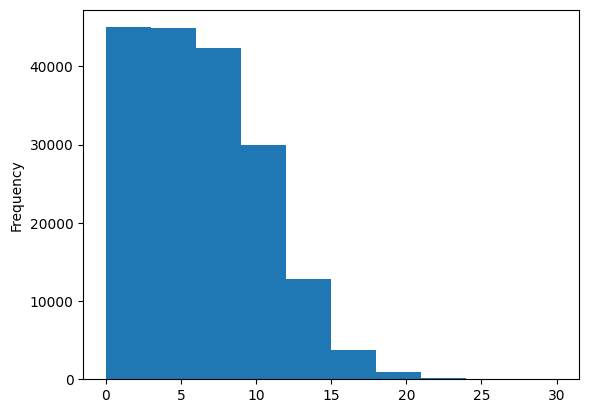

In [ ]:
#check distribution of line numbers

train_df["line_number"].plot.hist()

In [ ]:
np.percentile(train_df.total_lines, 98), np.percentile(train_df.line_number, 98)

(20.0, 15.0)

98 percentile of the total lines and line numbers are found and based on that we are going to limit our onehot encoding depth

Most of them are done by 15 so we encode only till 15 (as 30 will be too large to one hot encode) as most of the samples will be covered by 15


In [ ]:
#use tensorflow to create one hot encode the line numbers
# the reason for one hot encoding is to not let our model think value 2 is twice the 1 and value 4 is twice 2 in our line numbers

train_onehot_line_numbers = tf.one_hot(train_df["line_number"].to_numpy(), depth = 15)
val_onehot_line_numbers = tf.one_hot(val_df["line_number"].to_numpy(), depth = 15)
test_onehot_line_numbers = tf.one_hot(test_df["line_number"].to_numpy(), depth = 15)
train_onehot_line_numbers.shape, train_onehot_line_numbers[:15]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(15, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [ ]:
train_df.columns

Index(['target', 'text', 'line_number', 'total_lines'], dtype='object')

In [ ]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

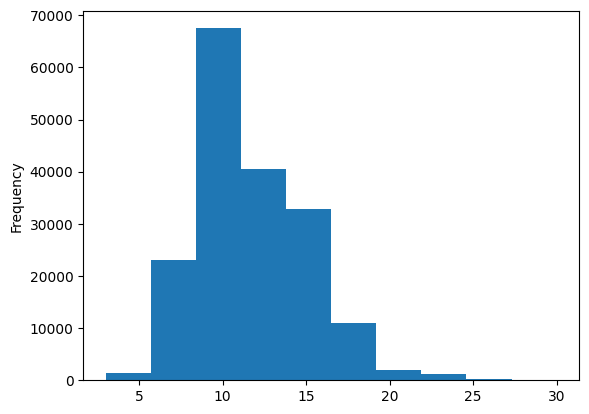

In [ ]:
train_df["total_lines"].plot.hist()

In [ ]:
train_onehot_total_lines = tf.one_hot(train_df["total_lines"].to_numpy(), depth = 20)
val_onehot_total_lines = tf.one_hot(val_df["total_lines"].to_numpy(), depth = 20)
test_onehot_total_lines = tf.one_hot(test_df["total_lines"].to_numpy(), depth = 20)
train_onehot_total_lines.shape, train_onehot_total_lines[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [ ]:
train_onehot_total_lines.dtype, train_onehot_line_numbers.dtype

(tf.float32, tf.float32)

#building a tribrid embedding model

1. create a token level model
2. create a character level model
3. create a "line_number" level model
4. create a "total_lines model
5. concatenate models 1 and 2
6. concatenate models 3 4 5
7. create an output layer for the tribrid model to accept tribrid embedding and output the label probabilities
8. combine inputs of 1 2 3 4 and outputs to tf.keras.Model

##model 5

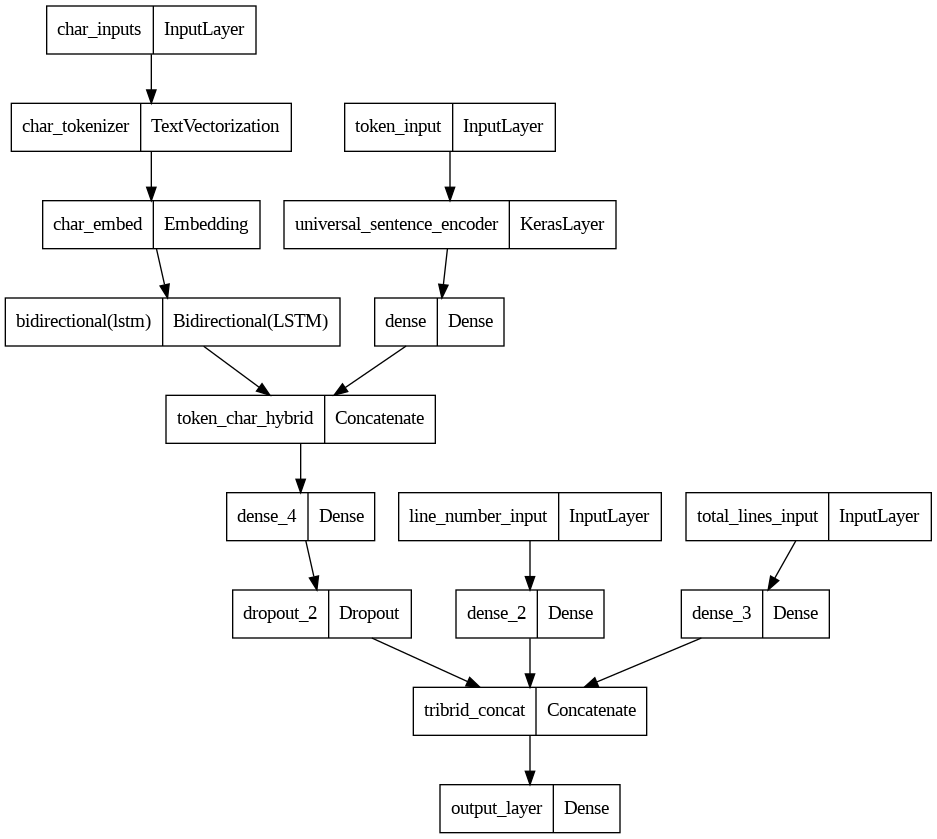

In [ ]:
# 1. token model
word_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_input")
word_embed = embed(word_inputs)
word_outputs = layers.Dense(128, activation = "relu")(word_embed)
word_model = tf.keras.Model(
    word_inputs,
    word_outputs,
    name = "words"
)

# 2. char model
char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = "char_inputs")
char_vector = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vector)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embedding)
char_model = tf.keras.Model(
    char_inputs,
    char_bi_lstm,
    name = "chars"
)

word_char_concat = layers.Concatenate(name = "token_char_hybrid")([word_model.output, char_model.output])
combined_dropout = layers.Dropout(0.5)(word_char_concat)
# combined_dense = layers.Dense(128, activation = "relu")(combined_dropout)
# final_dropout = layers.Dropout(0.5)(combined_dense)
# final_dense = layers.Dense(num_classes, activation = "softmax")(final_dropout)

token_char_dropout = layers.Dropout(0.5)(word_char_concat)
token_char_dense = layers.Dense(256, activation = "relu")(combined_dropout)

# 3. line number model
line_number_inputs = layers.Input(shape = (15,), dtype = tf.float32, name = "line_number_input")
x = layers.Dense(128, activation = 'relu')(line_number_inputs)
line_number_model = tf.keras.Model(
    line_number_inputs,
    x
)

# 4. total lines model
total_lines_inputs = layers.Input(shape = (20,), dtype = tf.float32, name = "total_lines_input")
y = layers.Dense(128, activation = 'relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(
    total_lines_inputs,
    y
)

# 5. token char concatencate
word_char_concat = layers.Concatenate(name = "token_char_hybrid")([word_model.output, char_model.output])
z = layers.Dense(128, activation = "relu")(word_char_concat)
z = layers.Dropout(0.5)(z)

# 6. tribrid model
tribrid_concat = layers.Concatenate(name = "tribrid_concat")([
    line_number_model.output,
    total_lines_model.output,
    z
])


output_layer = layers.Dense(num_classes, activation = "softmax", name = "output_layer")(tribrid_concat)

model_5 = tf.keras.Model(
    inputs=[
        line_number_model.inputs,
        total_lines_model.inputs,
        word_model.inputs,
        char_model.inputs
    ],
    outputs = output_layer,
    name = "tribrid_model"
)

from keras.utils import plot_model

plot_model(model_5)



```
# This is formatted as code
```

Now our model is constructed, let's compile it.

This time, we're going to introduce a new parameter to our loss function called `label_smoothing`. Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.

For example, instead of having an output prediction of:
* `[0.0, 0.0, 1.0, 0.0, 0.0]` for a sample (the model is very confident the right label is index 2).

It's predictions will get smoothed to be something like:
* `[0.01, 0.01, 0.096, 0.01, 0.01]` giving a small activation to each of the other labels, in turn, hopefully improving generalization.

> 📖 **Resource:** For more on label smoothing, see the great blog post by PyImageSearch, [*Label smoothing with Keras, TensorFlow, and Deep Learning*](https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/).

In [ ]:
model_5.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

##making final dataset

###train dataset

In [ ]:
#train_data
train_final_data = tf.data.Dataset.from_tensor_slices(
(    train_onehot_line_numbers,
    train_onehot_total_lines,
    train_sentences,
    train_chars)
)
#train labels
train_final_label = tf.data.Dataset.from_tensor_slices(train_onehot_encoded)
#combining them
train_final_dataset = tf.data.Dataset.zip((train_final_data, train_final_label))

#batching and prefetching to increase speed
train_final_dataset = train_final_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

###val_dataset

In [ ]:
val_final_data = tf.data.Dataset.from_tensor_slices(
    (val_onehot_line_numbers,
    val_onehot_total_lines,
    val_sentences,
    val_chars)
)

val_final_label = tf.data.Dataset.from_tensor_slices(val_onehot_encoded)

val_final_dataset = tf.data.Dataset.zip((val_final_data, val_final_label))
val_final_dataset = val_final_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#checking the input shapes
train_final_dataset, val_final_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

##fitting the tribrid model

In [ ]:
import os


def create_model_checkpoint(model_name, save_path = "Model_Experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path,model_name),
                                            verbose = 0, #output limited amount of text,
                                            monitor ="val_loss",
                                            save_best_only=True
                                            )

In [ ]:
history_5 = model_5.fit(
    train_final_dataset,
    epochs = 7,
    steps_per_epoch = len(train_final_dataset),
    validation_data = val_final_dataset,
    validation_steps = len(val_final_dataset),
    callbacks = [create_model_checkpoint(model_5.name)]
)


Epoch 1/7
5627/5627 [==============================] - ETA: 0s - loss: 0.9555 - accuracy: 0.8230

5627/5627 [==============================] - 349s 60ms/step - loss: 0.9555 - accuracy: 0.8230 - val_loss: 0.9094 - val_accuracy: 0.8506
Epoch 2/7
5627/5627 [==============================] - ETA: 0s - loss: 0.9152 - accuracy: 0.8519

5627/5627 [==============================] - 326s 58ms/step - loss: 0.9152 - accuracy: 0.8519 - val_loss: 0.8988 - val_accuracy: 0.8545
Epoch 3/7
5626/5627 [============================>.] - ETA: 0s - loss: 0.9036 - accuracy: 0.8606

5627/5627 [==============================] - 327s 58ms/step - loss: 0.9036 - accuracy: 0.8606 - val_loss: 0.8969 - val_accuracy: 0.8551
Epoch 4/7
5627/5627 [==============================] - ETA: 0s - loss: 0.8951 - accuracy: 0.8665

5627/5627 [==============================] - 331s 59ms/step - loss: 0.8951 - accuracy: 0.8665 - val_loss: 0.8949 - val_accuracy: 0.8568
Epoch 5/7
5627/5627 [==============================] - 285s 51ms/step - loss: 0.8885 - accuracy: 0.8709 - val_loss: 0.8970 - val_accuracy: 0.8559
Epoch 6/7
5627/5627 [==============================] - 283s 50ms/step - loss: 0.8827 - accuracy: 0.8754 - val_loss: 0.8978 - val_accuracy: 0.8540
Epoch 7/7
5627/5627 [==============================] - 278s 49ms/step - loss: 0.8778 - accuracy: 0.8788 - val_loss: 0.8971 - val_accuracy: 0.8546


In [ ]:
model_5.evaluate(val_final_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.8971 - accuracy: 0.8546


[0.8971331715583801, 0.8546273112297058]

In [ ]:
from google.colab import files

files.download("/content/Model_Experiments/tribrid_model")

FileNotFoundError: ignored

In [ ]:
# import tensorflow_hub as hub

# model_saved = tf.keras.models.load_model("kimlit_model_5.h5", custom_objects = {"KerasLayer": hub.KerasLayer})

model_5.save_model("my_model.h5")

# model_saved = tf.keras.models.load_model("/content/Model_Experiments/tribrid_model")

AttributeError: ignored

In [ ]:
model_saved.evaluate(val_final_dataset)

In [ ]:
model_5_pred_probs = model_5.predict(val_final_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis = 1)
model_5_preds[:5]

In [ ]:
res_5 = results(
    val_labels_le,
    model_5_preds
)

res_5

#Analysing results

##results dataframe

In [ ]:
results_df = pd.DataFrame({
    "multinomialNB": res_0,
    "custom_token": res_1,
    "USE": res_2,
    "custom_char": res_3,
    "char_word_combined": res_4,
    "tribrid": res_5
})

results_df= results_df.transpose()
results_df

Accuracy normalised

In [ ]:
results_df["Accuracy"] /= 100
results_df

##plotting all results

In [ ]:
results_df.plot(kind = "bar", figsize = (7,5)).legend(bbox_to_anchor=(1.0, 1.0))

Sorting

In [ ]:
results_df_sorted = results_df.sort_values("F1_Score", ascending = True)
results_df_sorted["F1_Score"].plot(kind = "bar")

* save our model
* try the custom token embedding layer
* try test data from pubmed website with rct(randomised control test) at the end
* see most wrong predictions

#model 6 low results

##Tribrid with cutsom token embed

In [ ]:
# # 1. token model
# word_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_input")
# word_vect = text_vect(word_inputs)
# word_embed = token_emb(word_vect)
# word_conv = layers.Conv1D(128, kernel_size = 5, activation = "relu", padding = "same")(word_embed)
# word_gap = layers.GlobalAveragePooling1D()(word_conv)
# word_outputs = layers.Dense(128, activation = "relu")(word_gap)
# word_model = tf.keras.Model(
#     word_inputs,
#     word_outputs,
#     name = "words"
# )

# # 2. char model
# char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = "char_inputs")
# char_vector = char_vectorizer(char_inputs)
# char_embedding = char_embed(char_vector)
# char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embedding)
# char_model = tf.keras.Model(
#     char_inputs,
#     char_bi_lstm,
#     name = "chars"
# )

# token_char_dropout = layers.Dropout(0.5)(word_char_concat)
# token_char_dense = layers.Dense(256, activation = "relu")(combined_dropout)

# # 3. line number model
# line_number_inputs = layers.Input(shape = (15,), dtype = tf.float32, name = "line_number_input")
# x = layers.Dense(128, activation = 'relu')(line_number_inputs)
# line_number_model = tf.keras.Model(
#     line_number_inputs,
#     x
# )

# # 4. total lines model
# total_lines_inputs = layers.Input(shape = (20,), dtype = tf.float32, name = "total_lines_input")
# y = layers.Dense(128, activation = 'relu')(total_lines_inputs)
# total_lines_model = tf.keras.Model(
#     total_lines_inputs,
#     y
# )

# # 5. token char concatencate
# word_char_concat = layers.Concatenate(name = "token_char_hybrid")([word_model.output, char_model.output])
# z = layers.Dense(128, activation = "relu")(word_char_concat)
# z = layers.Dropout(0.5)(z)

# # 6. tribrid model
# tribrid_concat = layers.Concatenate(name = "tribrid_concat")([
#     line_number_model.output,
#     total_lines_model.output,
#     z
# ])


# output_layer = layers.Dense(num_classes, activation = "softmax", name = "output_layer")(tribrid_concat)

# model_6 = tf.keras.Model(
#     inputs=[
#         line_number_model.inputs,
#         total_lines_model.inputs,
#         word_model.inputs,
#         char_model.inputs
#     ],
#     outputs = output_layer,
#     name = "tribrid_model"
# )

# plot_model(model_6)

##fitting and compilation

In [ ]:
# model_6.compile(
#     loss = "categorical_crossentropy",
#     optimizer = tf.keras.optimizers.Adam(),
#     metrics = ["accuracy"]
# )

# model_6.fit(
#     train_final_dataset,
#     steps_per_epoch = len(train_final_dataset),
#     epochs = 3,
#     validation_data = val_final_dataset,
#     validation_steps = len(val_final_dataset)
# )